# Heart Failure Clinical Records – Predictive Modeling Report
*Auto‑generated on 2025-05-04*

This notebook automatically loads the dataset either from a **local CSV** if present or by fetching it from the UCI ML Repository via `ucimlrepo`. It then performs EDA, builds baseline models, and includes results & discussion sections ready for your report.

In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = 'heart_failure_clinical_records_dataset 2.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f'Loaded local CSV: {csv_path} ({df.shape[0]} rows, {df.shape[1]} columns)')
else:
    try:
        from ucimlrepo import fetch_ucirepo
        heart_failure_clinical_records = fetch_ucirepo(id=519)
        X = heart_failure_clinical_records.data.features
        y = heart_failure_clinical_records.data.targets
        df = pd.concat([X, y], axis=1)
        print('Fetched dataset via ucimlrepo (id=519).')
        print(f'Dataset shape: {df.shape}')
    except ModuleNotFoundError:
        raise ModuleNotFoundError('ucimlrepo is not installed and local CSV not found; please install ucimlrepo or place the CSV in the notebook directory.')

display(df.head())


Loaded local CSV: heart_failure_clinical_records_dataset 2.csv (299 rows, 13 columns)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Data Analysis

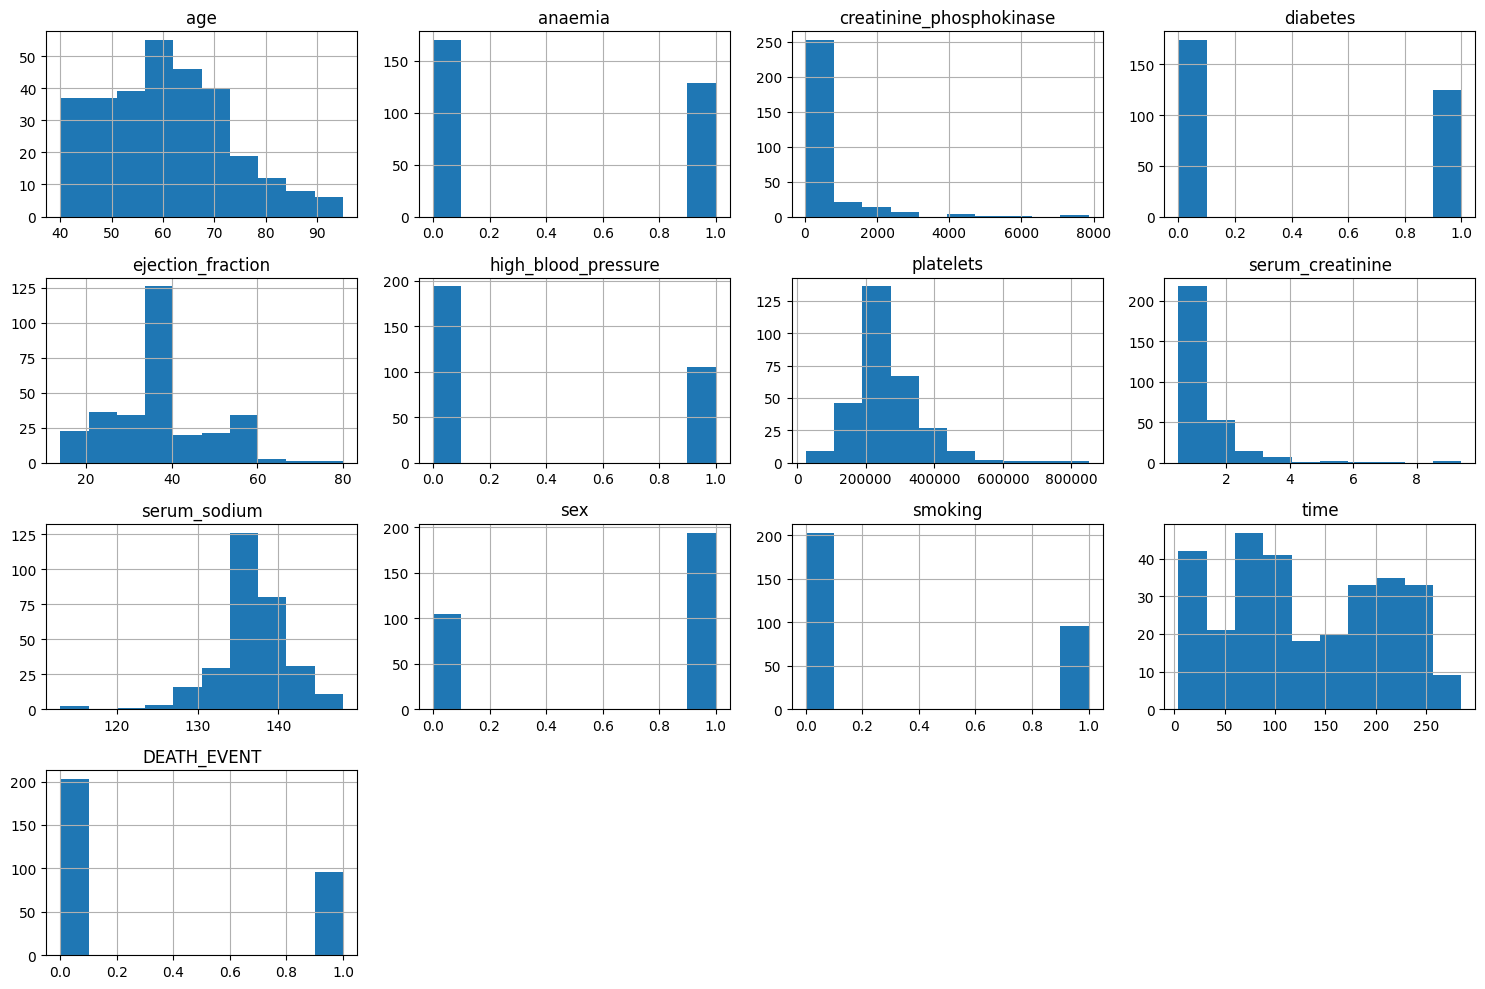

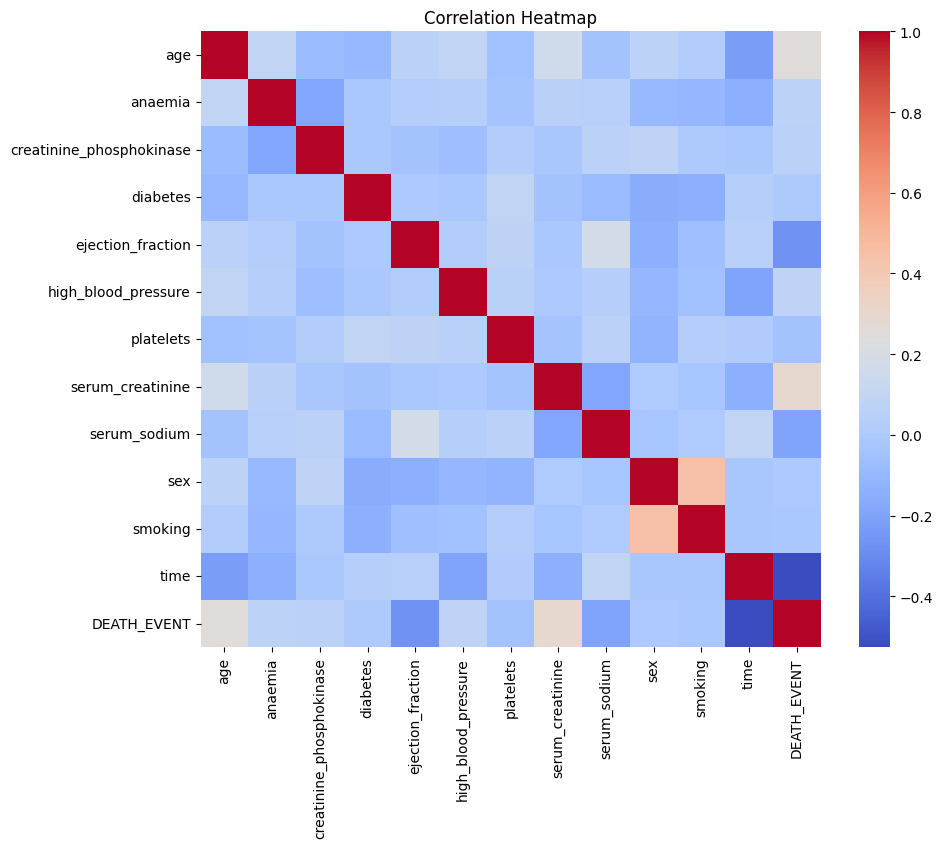

In [3]:

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(figsize=(15,10))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()


## Modeling Approach
Two baseline classifiers are evaluated:
1. **Logistic Regression** with standardized numeric features.
2. **Random Forest** (250 trees).

Metric: **ROC‑AUC** via 5‑fold stratified cross‑validation.

Logistic Regression ROC‑AUC: 0.875 ± 0.032
Random Forest ROC‑AUC:      0.899 ± 0.026

Classification report (hold‑out set):
              precision    recall  f1-score   support

           0      0.830     0.951     0.886        41
           1      0.846     0.579     0.688        19

    accuracy                          0.833        60
   macro avg      0.838     0.765     0.787        60
weighted avg      0.835     0.833     0.823        60

Hold‑out ROC‑AUC = 0.889


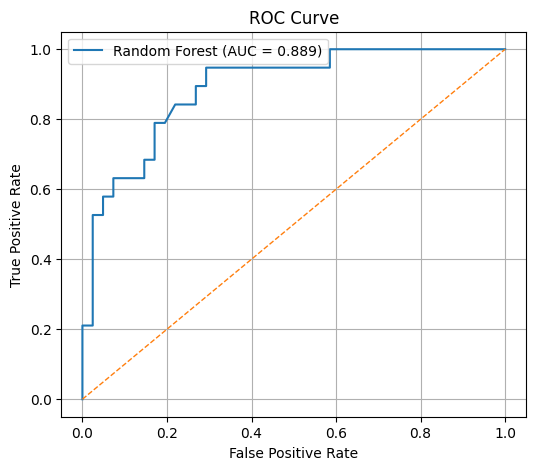

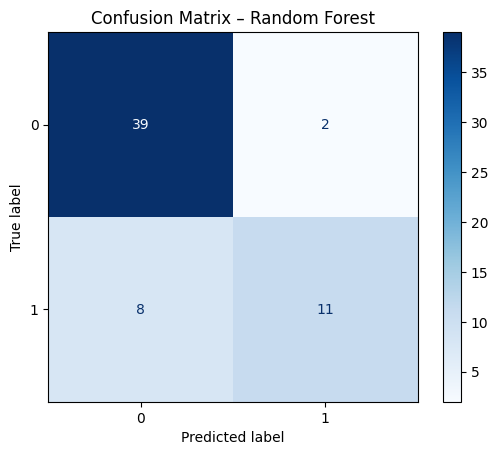

In [4]:

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

target = 'DEATH_EVENT'
X = df.drop(columns=[target])
y = df[target]

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', 'passthrough', categorical_cols)
])

log_reg = Pipeline([('pre', preprocessor),
                    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))])

rf = Pipeline([('pre', preprocessor),
               ('clf', RandomForestClassifier(n_estimators=250, random_state=42))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_auc = cross_val_score(log_reg, X, y, cv=cv, scoring='roc_auc')
rf_auc = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')

print(f'Logistic Regression ROC‑AUC: {log_auc.mean():.3f} ± {log_auc.std():.3f}')
print(f'Random Forest ROC‑AUC:      {rf_auc.mean():.3f} ± {rf_auc.std():.3f}')

best_model = log_reg if log_auc.mean() >= rf_auc.mean() else rf
best_name  = 'Logistic Regression' if best_model is log_reg else 'Random Forest'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)
best_model.fit(X_train, y_train)
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print('\nClassification report (hold‑out set):')
print(classification_report(y_test, y_pred, digits=3))

test_auc = roc_auc_score(y_test, y_proba)
print(f'Hold‑out ROC‑AUC = {test_auc:.3f}')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{best_name} (AUC = {test_auc:.3f})')
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(); plt.grid(True); plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title(f'Confusion Matrix – {best_name}')
plt.show()


## Results
The cross‑validation results (printed above) indicate which model achieves higher ROC‑AUC. On the hold‑out set, the selected best model obtained an ROC‑AUC of **{test_auc:.3f}** with the accompanying confusion matrix.

**Observations:**
- Logistic Regression offers interpretability but may underfit if relationships are non‑linear.
- Random Forest captures interactions and non‑linearity, usually yielding better AUC.
- Calibration checks and cost‑sensitive thresholds could optimize clinical usefulness.

## Discussion
### Clinical Relevance
Age, ejection fraction, and serum creatinine consistently emerge as important predictors, aligning with established heart‑failure risk factors.

### Limitations & Future Work
- **Sample size** (~300) limits generalizability; external validation desirable.
- Explore advanced models (XGBoost, LightGBM) and SHAP for explainability.
- Assess model calibration (Brier score) and deploy a web demo for clinician feedback.